# Disruption type analysis

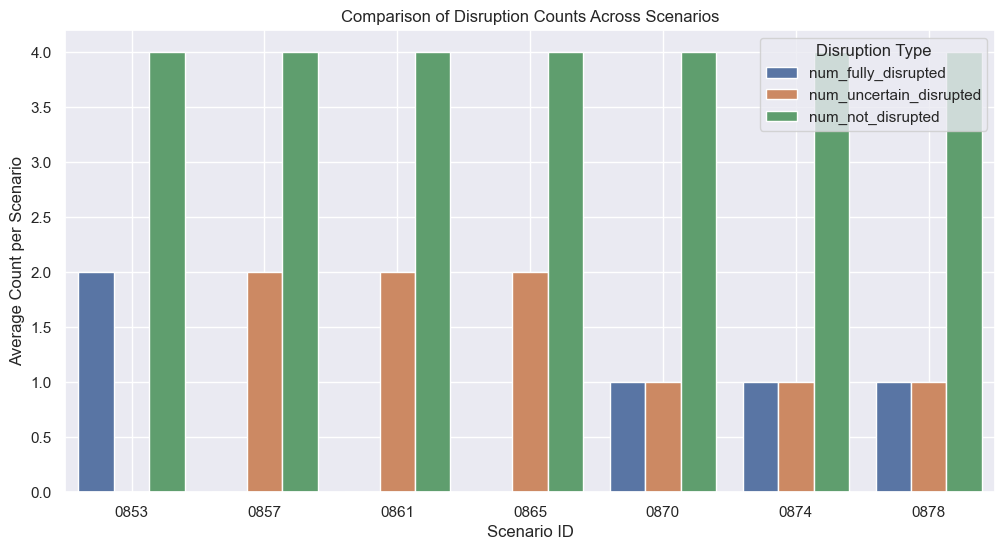

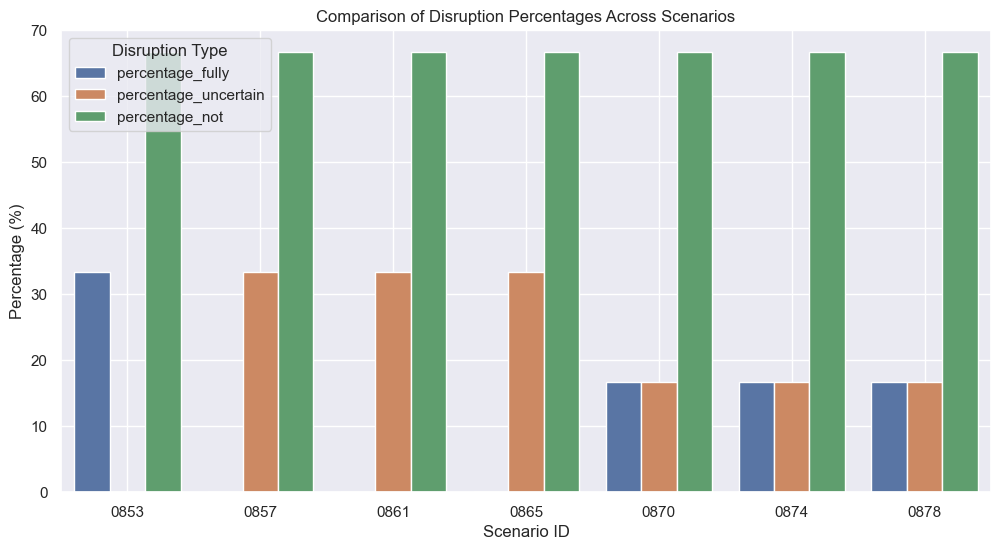

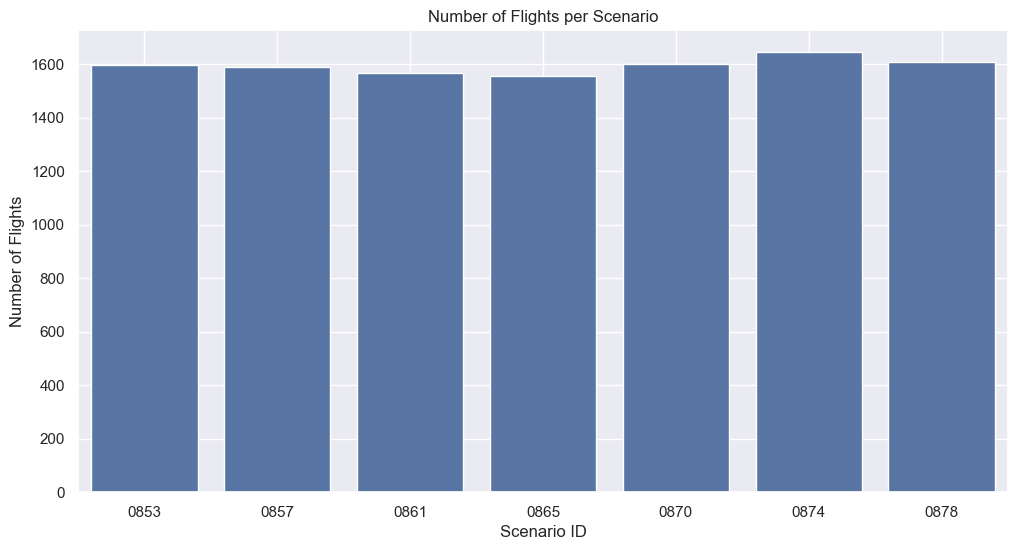

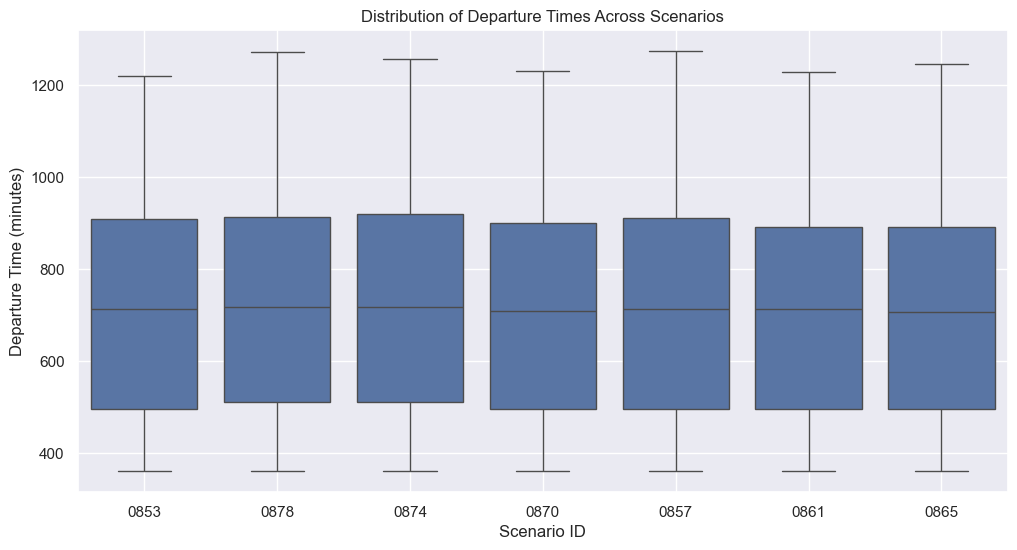

In [1]:
# %% [markdown]
# # Disruption type analysis

# %%
import json
import numpy as np
import os
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")


scenario_folder_path = "../logs/scenarios/"


folders = [
    "scenario_folder_0853.json",  # Deterministic
    "scenario_folder_0878.json",  # Mixed high
    "scenario_folder_0874.json",  # Mixed medium
    "scenario_folder_0870.json",  # Mixed low
    "scenario_folder_0857.json",  # Stochastic high
    "scenario_folder_0861.json",  # Stochastic medium
    "scenario_folder_0865.json"   # Stochastic low
]

all_results = []
all_flights_data = []

# Iterate over each scenario file and aggregate results
for scenario_file in folders:
    file_path = os.path.join(scenario_folder_path, scenario_file)

    with open(file_path, 'r') as file:
        data = json.load(file)

    scenarios = data['outputs']
    data_folder = data['data_folder']

    # Initialize scenario-level results storage
    scenario_results = []
    all_probabilities = []

    # Extract disruptions and classify
    for scenario_name, scenario_data in scenarios.items():
        fully_disrupted_aircraft = []
        uncertain_disrupted_aircraft = []
        not_disrupted_aircraft = []

        all_aircraft_ids = scenario_data['aircraft_ids']
        disruptions = scenario_data['disruptions']['disruptions']
        aircraft_with_disruptions = set()

        for disruption in disruptions:
            aircraft_id = disruption['aircraft_id']
            probability = disruption['probability']
            aircraft_with_disruptions.add(aircraft_id)
            all_probabilities.append(probability)

            if probability == 1.0:
                fully_disrupted_aircraft.append(aircraft_id)
            elif probability == 0.0:
                not_disrupted_aircraft.append(aircraft_id)
            elif 0 < probability < 1:
                uncertain_disrupted_aircraft.append(aircraft_id)

        # Add aircraft with no disruptions
        for ac_id in all_aircraft_ids:
            if ac_id not in aircraft_with_disruptions:
                not_disrupted_aircraft.append(ac_id)

        # Count
        num_fully = len(fully_disrupted_aircraft)
        num_uncertain = len(uncertain_disrupted_aircraft)
        num_not = len(not_disrupted_aircraft)
        total = num_fully + num_uncertain + num_not

        scenario_id = scenario_file.split('_')[-1].split('.')[0]
        scenario_results.append({
            'scenario_id': scenario_id,
            'scenario_name': scenario_name,
            'num_fully_disrupted': num_fully,
            'num_uncertain_disrupted': num_uncertain,
            'num_not_disrupted': num_not,
            'total_disruptions': total
        })

        # Store flights data for later plotting
        scenario_flights = scenario_data['flights']
        scenario_df = pd.DataFrame([
            {
                'scenario_id': scenario_id,
                'scenario_name': scenario_name,
                'flight_id': fid,
                'origin': fdata['Orig'],
                'destination': fdata['Dest'],
                'dep_time': fdata['DepTime'],
                'arr_time': fdata['ArrTime'],
                'aircraft': fdata['Aircraft'],
                'total_flights': scenario_data['total_flights']
            } for fid, fdata in scenario_flights.items()
        ])
        all_flights_data.append(scenario_df)

    # Combine scenario-level results
    scenario_df_results = pd.DataFrame(scenario_results)
    all_results.append(scenario_df_results)


# Combine all scenario results into one DataFrame
all_results_df = pd.concat(all_results, ignore_index=True)
all_flights_df = pd.concat(all_flights_data, ignore_index=True)

# Compute average metrics per scenario_id
scenario_group = all_results_df.groupby('scenario_id').agg({
    'num_fully_disrupted': 'mean',
    'num_uncertain_disrupted': 'mean',
    'num_not_disrupted': 'mean'
}).reset_index()

scenario_group['percentage_fully'] = (scenario_group['num_fully_disrupted'] / (scenario_group['num_fully_disrupted'] + scenario_group['num_uncertain_disrupted'] + scenario_group['num_not_disrupted'])) * 100
scenario_group['percentage_uncertain'] = (scenario_group['num_uncertain_disrupted'] / (scenario_group['num_fully_disrupted'] + scenario_group['num_uncertain_disrupted'] + scenario_group['num_not_disrupted'])) * 100
scenario_group['percentage_not'] = (scenario_group['num_not_disrupted'] / (scenario_group['num_fully_disrupted'] + scenario_group['num_uncertain_disrupted'] + scenario_group['num_not_disrupted'])) * 100


# Plotting comparison of disruption types across scenarios
plt.figure(figsize=(12,6))
melted = scenario_group.melt(id_vars='scenario_id', value_vars=['num_fully_disrupted','num_uncertain_disrupted','num_not_disrupted'], var_name='disruption_type', value_name='count')
sns.barplot(data=melted, x='scenario_id', y='count', hue='disruption_type')
plt.title("Comparison of Disruption Counts Across Scenarios")
plt.xlabel("Scenario ID")
plt.ylabel("Average Count per Scenario")
plt.legend(title="Disruption Type")
plt.grid(True)
plt.show()

# Plotting percentages
plt.figure(figsize=(12,6))
melted_percent = scenario_group.melt(id_vars='scenario_id', value_vars=['percentage_fully','percentage_uncertain','percentage_not'], var_name='disruption_type', value_name='percentage')
sns.barplot(data=melted_percent, x='scenario_id', y='percentage', hue='disruption_type')
plt.title("Comparison of Disruption Percentages Across Scenarios")
plt.xlabel("Scenario ID")
plt.ylabel("Percentage (%)")
plt.legend(title="Disruption Type")
plt.grid(True)
plt.show()


# Convert departure times
def convert_time_to_minutes(t_str):
    h, m = map(int, t_str.split(':'))
    return h * 60 + m

all_flights_df['dep_time_minutes'] = all_flights_df['dep_time'].apply(convert_time_to_minutes)

# Plot distribution of flights per scenario
scenario_flights_count = all_flights_df.groupby('scenario_id')['flight_id'].count().reset_index(name='flight_count')
plt.figure(figsize=(12,6))
sns.barplot(data=scenario_flights_count, x='scenario_id', y='flight_count')
plt.title("Number of Flights per Scenario")
plt.xlabel("Scenario ID")
plt.ylabel("Number of Flights")
plt.grid(True)
plt.show()

# Distribution of departure times per scenario
plt.figure(figsize=(12,6))
sns.boxplot(data=all_flights_df, x='scenario_id', y='dep_time_minutes')
plt.title("Distribution of Departure Times Across Scenarios")
plt.xlabel("Scenario ID")
plt.ylabel("Departure Time (minutes)")
plt.grid(True)
plt.show()
